# Introduction

Using the development version of [scikit-learn](http://scikit-learn.org/dev/documentation.html), we construct a neural network (NN) regression model to map from a quantum mechanical potential to the energy levels (eigenvalues) for the single-particle system. The potential $V(x)$ is defined in the range $x\in [-1,1]$ and has the boundary conditions $V(\pm 1) = \infty$. The primary purpose of this notebook is to determine the optimal parameters of the NN. We do this using $10^4$ training examples. We train using these parameters. 

The potentials used for training and testing are generated in [potentials.ipynb](potentials.ipynb). The eigenvalues for all potentials are calculated in [eigenvalues.ipynb](eigenvalues.ipynb).

Documentation for `sklearn`'s supervised NN tools can be found here: http://scikit-learn.org/dev/modules/neural_networks_supervised.html. While already quite good, this documentation still appears to be "under construction".

# Preliminaries

In [1]:
%matplotlib inline
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
import pprint
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# Number of basis states for the wavefunctions
NBW = 50
nbws = np.arange(1, NBW+1)
# Number of potentials:
NV = int(1E4)
# Number of basis states in the potential:
NB = 10
ns = np.arange(1, NB+1)
# lambda (variance of Legendre coefficients):
lam = 0.75
# The variance of the n=0 legendre coefficient V_0:
V20 = 10

# Input file:
filepath = "../Data/eigenvalues_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
filepathSD = "../Data/eigenvaluesSD_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
data = np.load(filepath)
dataSD = np.load(filepathSD)
VSns = data[::,0:10]
VCns = data[::,10:20]
eigs = data[::,20::]

In [3]:
print("Data shape: ", data.shape, 
      "\nSine coefficients shape: ", VSns.shape,
      "\nCosine coefficients shape: ", VCns.shape, eigs.shape,
      "\nStd. dev. shape: ", dataSD.shape
     )

Data shape:  (10000, 60) 
Sine coefficients shape:  (10000, 10) 
Cosine coefficients shape:  (10000, 10) (10000, 40) 
Std. dev. shape:  (40,)


# Preprocessing

We know that the spectrum is symmetric under $x\to -x$. We can build this into our dataset. To do this, we duplicate the entire dataset but set all the Sine coefficients to their negative value. This is equivalent to taking $x\to-x$.

We extract the values of the potentials at a discreet, linear grid of $x$ points: $\left\{V(x) \,\, \mid \,\, x \in \{x_1,\,x_2,\ldots,x_{N_x}\}\right\}$. This grid of potential values will serve as the input to our NN model.

In [4]:
# We first define functios that help us map the Fourier-space potentials into coordinate space.
def VS(ns, xs):
    return np.sin(np.pi*np.outer(ns,xs))
def VC(ns, xs):
    return np.cos(np.pi*np.outer(ns,xs))

In [5]:
# Number of x coordinates:
Nx = 200
xs = np.linspace(-1,1,Nx)

# The coordinate space potentials:
VSs = VS(ns,xs)
VCs = VC(ns,xs)
Vgrid = np.dot(VSns,VSs) + np.dot(VCns,VCs)
VgridFlipped = np.dot(-VSns,VSs) + np.dot(VCns,VCs)

# Make sure the flip worked by looking at a random potential:
rint = randint(0, NV)
print("First 4 values of Vgrid["+str(rint)+"]:" , Vgrid[rint][0:4])
print("Last 4 values of VgridFlipped["+str(rint)+"]:", VgridFlipped[rint][-4::])

First 4 values of Vgrid[3830]: [-0.07250594 -0.467126   -0.88626739 -1.3135663 ]
Last 4 values of VgridFlipped[3830]: [-1.3135663  -0.88626739 -0.467126   -0.07250594]


In [6]:
numeigs = 10
X = np.concatenate( (Vgrid, VgridFlipped) )
y = np.concatenate( (eigs, eigs) )[::,1:numeigs+1]

In [7]:
# Split test and train
test_frac = 0.4
random_state = 5
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=random_state
)
print("X shape, y shape: ", X.shape, y.shape)
print("X_train shape, y_train shape: ", X_train.shape, y_train.shape)
print("X_test shape, y_test shape: ", X_test.shape, y_test.shape)

X shape, y shape:  (20000, 200) (20000, 10)
X_train shape, y_train shape:  (12000, 200) (12000, 10)
X_test shape, y_test shape:  (8000, 200) (8000, 10)


# Neural network

## Pipeline
We build a pipeline with 2 steps:

1. Scale the inputs.
2. Train the Neural network.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

In [9]:
# The Scaler
scale = StandardScaler(with_std=False)

# The NN regression model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
hidden_layers = (100,)
regr =MLPRegressor(hidden_layer_sizes=hidden_layers,
                  activation = 'tanh',
                  algorithm = 'adam',
                  alpha = 0.1,
                  beta_1 = 0.85,
                  beta_2 = 0.9,
                  batch_size = 'auto',
                  max_iter = 500,
                  tol = 1e-6,
                  learning_rate_init = 0.001,
                  verbose = False
                 )

steps = [('scale', scale), ('regr', regr)]
model = Pipeline(steps)
#pprint.pprint(model.get_params())

## Model selection
We now use grid search to determine the optimum values of some import hyperparameters for the neural network model. For descriptions of the neural network parameters, the `scikit-learn` documentation for [`sklearn.neural_network.MLPRegressor`](http://scikit-learn.org/dev/modules/generated/sklearn.neural_network.MLPRegressor.html).

### Architecture tuning

#### A single hidden layer

In [10]:
from sklearn.model_selection import GridSearchCV
# params_A1 = dict(
#     regr__hidden_layer_sizes = [(20,),(30,),(40,),(50,),(60,),(70,),(80,),(90,),(100,)]
#     )

# model_gs_A1 = GridSearchCV(model, 
#                         param_grid = params_A1,
#                         verbose = 4
#                        )
# model_gs_A1.fit(X_train, y_train);

In [11]:
# print("Optimal_params: ", model_gs_A1.best_params_)
# A1_df = pd.DataFrame(model_gs_A1.results_)

#### Two hidden layers

In [12]:
params_A2 = dict(
    regr__hidden_layer_sizes = [(40,10),(40,20),(40,30),(40,40),(40,50),(40,60),(40,70),
                                (50,10),(50,20),(50,30),(50,40),(50,50),(50,60),(50,70),
                               (60,10),(60,20),(60,30),(60,40),(60,50),(60,60),(60,70),
                               (70,10),(70,20),(70,30),(70,40),(70,50),(70,60),(70,70),
                               (80,10),(80,20),(80,30),(80,40),(80,50),(80,60),(80,70),
                               (90,10),(90,20),(90,30),(90,40),(90,50),(90,60),(90,70)]
    )

model_gs_A2 = GridSearchCV(model, 
                        param_grid = params_A2,
                        verbose = 4
                       )
model_gs_A2.fit(X_train, y_train);

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV] regr__hidden_layer_sizes=(40, 10) ...............................
[CV] ...... regr__hidden_layer_sizes=(40, 10), score=0.927412 -  12.3s
[CV] regr__hidden_layer_sizes=(40, 10) ...............................
[CV] ...... regr__hidden_layer_sizes=(40, 10), score=0.946137 -  15.8s
[CV] regr__hidden_layer_sizes=(40, 10) ...............................
[CV] ...... regr__hidden_layer_sizes=(40, 10), score=0.947047 -  18.4s
[CV] regr__hidden_layer_sizes=(40, 20) ...............................
[CV] ...... regr__hidden_layer_sizes=(40, 20), score=0.955486 -  16.9s
[CV] regr__hidden_layer_sizes=(40, 20) ...............................
[CV] ...... regr__hidden_layer_sizes=(40, 20), score=0.953705 -  18.5s
[CV] regr__hidden_layer_sizes=(40, 20) ...............................
[CV] ...... regr__hidden_layer_sizes=(40, 20), score=0.950972 -  19.5s
[CV] regr__hidden_layer_sizes=(40, 30) ...............................
[CV] ...... reg

[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:  7.9min


[CV] ...... regr__hidden_layer_sizes=(50, 20), score=0.957267 -  18.3s
[CV] regr__hidden_layer_sizes=(50, 20) ...............................
[CV] ...... regr__hidden_layer_sizes=(50, 20), score=0.953642 -  19.2s
[CV] regr__hidden_layer_sizes=(50, 20) ...............................
[CV] ...... regr__hidden_layer_sizes=(50, 20), score=0.957683 -  18.6s
[CV] regr__hidden_layer_sizes=(50, 30) ...............................
[CV] ...... regr__hidden_layer_sizes=(50, 30), score=0.964520 -  22.2s
[CV] regr__hidden_layer_sizes=(50, 30) ...............................
[CV] ...... regr__hidden_layer_sizes=(50, 30), score=0.960496 -  20.6s
[CV] regr__hidden_layer_sizes=(50, 30) ...............................
[CV] ...... regr__hidden_layer_sizes=(50, 30), score=0.961832 -  21.1s
[CV] regr__hidden_layer_sizes=(50, 40) ...............................
[CV] ...... regr__hidden_layer_sizes=(50, 40), score=0.966997 -  24.2s
[CV] regr__hidden_layer_sizes=(50, 40) ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  97 tasks       | elapsed: 34.4min


[CV] ...... regr__hidden_layer_sizes=(80, 50), score=0.967610 -  25.3s
[CV] regr__hidden_layer_sizes=(80, 50) ...............................
[CV] ...... regr__hidden_layer_sizes=(80, 50), score=0.970148 -  22.6s
[CV] regr__hidden_layer_sizes=(80, 60) ...............................
[CV] ...... regr__hidden_layer_sizes=(80, 60), score=0.974492 -  24.5s
[CV] regr__hidden_layer_sizes=(80, 60) ...............................
[CV] ...... regr__hidden_layer_sizes=(80, 60), score=0.969508 -  22.8s
[CV] regr__hidden_layer_sizes=(80, 60) ...............................
[CV] ...... regr__hidden_layer_sizes=(80, 60), score=0.969018 -  24.8s
[CV] regr__hidden_layer_sizes=(80, 70) ...............................
[CV] ...... regr__hidden_layer_sizes=(80, 70), score=0.971460 -  22.5s
[CV] regr__hidden_layer_sizes=(80, 70) ...............................
[CV] ...... regr__hidden_layer_sizes=(80, 70), score=0.968927 -  23.0s
[CV] regr__hidden_layer_sizes=(80, 70) ...............................
[CV] .

[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed: 46.1min finished


In [13]:
print("Optimal_params: ", model_gs_A2.best_params_)
A2_df = pd.DataFrame(model_gs_A2.results_)

Optimal_params:  {'regr__hidden_layer_sizes': (90, 70)}


#### Plot of architecture dependence

In [14]:
A2_df.columns

Index(['param_regr__hidden_layer_sizes', 'params', 'test_mean_score',
       'test_rank_score', 'test_split0_score', 'test_split1_score',
       'test_split2_score', 'test_std_score'],
      dtype='object')

ValueError: x and y must have same first dimension

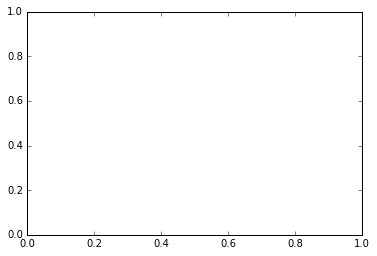

In [15]:
x = np.linspace(1,10,9)
plt.xlim = [0,11]
# plt.plot(x, np.abs(1-A1_df.test_mean_score), color = 'r', marker = 'o', label="1 layer")
plt.plot(x, np.abs(1-A2_df.test_mean_score), color = 'b', marker = '^', label="2 layers")
plt.axis([0, 11, 0, 0.1])
plt.xlabel('Parameter case')
plt.ylabel('% Error')
plt.show()

We will use the 6th case of the single-layer NN. Beyond this point, you get diminishing returns, and it doesn't appear that the 2-layer network offers any improvement.

### Hyperparameter tuning

In [ ]:
params_P = dict(
    regr__hidden_layer_sizes = [(50,50)],
    regr__alpha = [0.09, 0.1,0.11],
    regr__beta_1 = [0.75, 0.85],
    regr__beta_2 = [0.8,0.9]
    )

model_gs_P = GridSearchCV(model, 
                        param_grid = params_P,
                        verbose = 4
                       )
model_gs_P.fit(X_train, y_train)

In [ ]:
print("Best parameters:\n ", model_gs_P.best_params_)
print("Best score:\n", model_gs_P.best_score_)
model_best = model_gs_P.best_estimator_

In [ ]:
model_best.set_params(regr__verbose = True, regr__warm_start = True)
model_best.fit(X_train, y_train)

In [ ]:
# Save the network:
from sklearn.externals import joblib
filepath = "../Data/NN/NN" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".pkl"
joblib.dump(model_best, filepath);

## Validation

We now test the NN on the test set. We measure the error for each eigenvalue relative to the width of the distribution of that eigenvalue over all of the generated potentials. Alternatively (and similarly) one could measure the error relative to the error incurred by simply guessing that the correct value equaled the uniform square-well value.

In [ ]:
y_pred = model_best.predict(X_test)
y_scaled_err = np.sqrt(np.mean((y_pred - y_test)**2/dataSD[0:numeigs]**2, axis = 0))
print("Scaled RMS error by eigenvalue:\n", y_scaled_err)
print("Average of scaled RMS errors:\n ", np.mean(np.abs(y_scaled_err)))

# Visualizing the results

In [ ]:
nrows = 1
ncols = 4
nplot = nrows * ncols
indplt = randint(0,X_test.shape[0], nplot)
numeigsplt = 4

def E0(n):
    return n**2 * np.pi**2 / 8.

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(3*ncols,10*nrows)
subax = axes.flat

for i in range(0, len(indplt)):
        subax[i].plot(xs, X_test[indplt[i]], linewidth = 2, label='$V(x)$')
        subax[i].axhline(y=0,xmin=-1,xmax=1, linestyle='solid' ,color = 'k', lw=0.5)
        for j in range(0, numeigsplt):
            lastaxNN = subax[i].axhline(y=E0(j+1)+y_pred[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'solid', color = 'r', lw = 3, label = 'Neural Network')
            lastaxSE = subax[i].axhline(y=E0(j+1)+y_test[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'dashed', color = 'k', lw =3, label = 'Schr. Eqn.')

        subax[i].set_xlabel("x")
        subax[i].set_ylabel("V(x)")
        subax[i].set_ylim((-V20, 1.2*E0(numeigsplt)))
        subax[i].legend([lastaxNN, lastaxSE], ["Neural Network", "Schr. Eqn."])

plt.tight_layout();
plt.show();
plt.draw()
fig.savefig("../Plots/NNPred.png")